In [1]:
import numpy as np
import torch
from torch.distributions.normal import Normal

import pyro
import pyro.distributions as dist

from generation_with_evaluation_period import generative_procedure_with_evaluation_period, generative_procedure_future
from generation_with_evaluation_period import plot_time_series
import kalman_filter
from kalman_smoothing import kalman_smoothing
from fake_path_trick import fake_path_trick
from likelihood import log_likelihood

from change_point_and_anomaly import update_p_a_t, update_p_c_t
from change_point_and_anomaly import generate_z_a_t, generate_z_c_t
from change_point_and_anomaly import  segment_control

from update_params import update_sigma_e, update_sigma_o, update_sigma_u, update_sigma_r, update_sigma_delta, update_sigma_gamma



from likelihood import log_likelihood
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt

# Data Generation

In [2]:
L = 500
L_train = 350

S = 7

sigma_e = 0.1
sigma_u = 0.1
sigma_v = 0.0004
sigma_w = 0.01
sigma_r = 1.
sigma_o = 4.

# alpha_1

mu_0 = 20.
delta_0 = 0.

#?????????????????????????????????????????????????????
gamma_0 = np.array([1,2,4,-1,-3,-2]) / 10 #gamma_{-1}, ..., gamma_{2-S} or gamma_{2-S}, ..., gamma_{-1}




p_c = 4 / 350
p_a = 10 / 350

t_c_fixed = 330 - 1
c_fixed = 1.
t_r_fixed = 330 - 1
r_fixed = 2.
#end of info part!!!!!!!!!!!!!!!!!!!!

In [3]:
torch.manual_seed(5)

(y, mu, delta, gamma, mu_with_initial_values, delta_with_initial_values, gamma_with_initial_values, gamma_vec, z_a, z_c) = generative_procedure_with_evaluation_period(mu_0, delta_0, gamma_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, p_a, p_c, L, L_train, S, t_c_fixed, c_fixed, t_r_fixed, r_fixed)

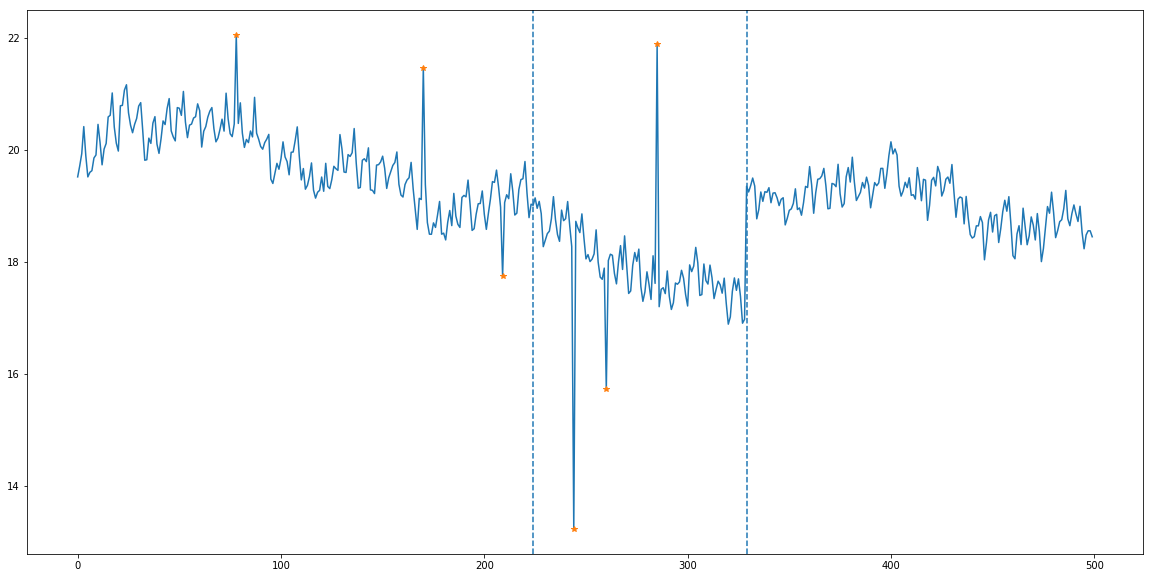

In [4]:
plot_time_series(y, z_a, z_c)

# Initialization

In [5]:
z_a_true = z_a #tensor
z_c_true = z_c #tensor
sigma_true = [sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]

p_a_true = p_a
p_c_true = p_c

In [6]:
z_a_evolution = []
z_c_evolution = []
p_a_evolution = []
p_c_evolution = []

sigma_evolution = []

a_1_evolution = []

a_1_true = np.zeros(S+1)
a_1_true[0] = mu_0
a_1_true[1] = delta_0
a_1_true[2:] = gamma_0



## 1. initialize sigma

In [7]:
y_train = y[:L_train]

y_mean = y[:L_train].mean().item()
sigma_sqr = (sum((y_train - y_mean) ** 2) / (L_train - 1)).item()
sigma = sqrt(sigma_sqr)
sigma_e = sigma_u = sigma_v = sigma_w = sigma_r = sigma_o = torch.DoubleTensor([sigma]) #?????????


sigma_v = 0.0001


#--------- fake ---------------

sigma_e = 0.1
sigma_u = 0.1
sigma_v = 0.0004
sigma_w = 0.01
sigma_r = 1.
sigma_o = 4.



#------------------------------

print('sigma:     ', sigma)
print('sigma_true:', sigma_true)

sigma:      1.1086372784978837
sigma_true: [0.1, 4.0, 0.1, 1.0, 0.0004, 0.01]


In [8]:
# y_train - tensor torch.float64
# y_mean - number
# sigma - number

sigma_evolution.append(np.array([sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]))


## 2. initialize a_1

In [9]:
a_1 = kalman_filter.gen_a_1(S, y_train)

In [10]:
#a_1 - tensor torch.float64

print('a_1', a_1)

a_1 tensor([[19.7959],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], dtype=torch.float64)


## 3. initialize p and z

In [11]:
p_a = p_c = 1 / L_train

#------fake-----------

# p_c = 4 / 350
# p_a = 10 / 350


#---------------------

dist_a = dist.Bernoulli(p_a)
dist_c = dist.Bernoulli(p_c)

z_a = dist_a.sample((L_train,))
z_c = dist_c.sample((L_train,))

In [12]:
p_a_evolution.append(p_a * np.ones(L_train))
p_c_evolution.append(p_c * np.ones(L_train))
z_a_evolution.append(z_a)
z_c_evolution.append(z_c)

In [13]:
# z_a, z_c - tensors dtype = ??????????

In [14]:
print('p_a = p_c =', p_a)
print('p_a_true  =', p_a_true)
print('p_c_true  =', p_c_true)

p_a = p_c = 0.002857142857142857
p_a_true  = 0.02857142857142857
p_c_true  = 0.011428571428571429


# Inference

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

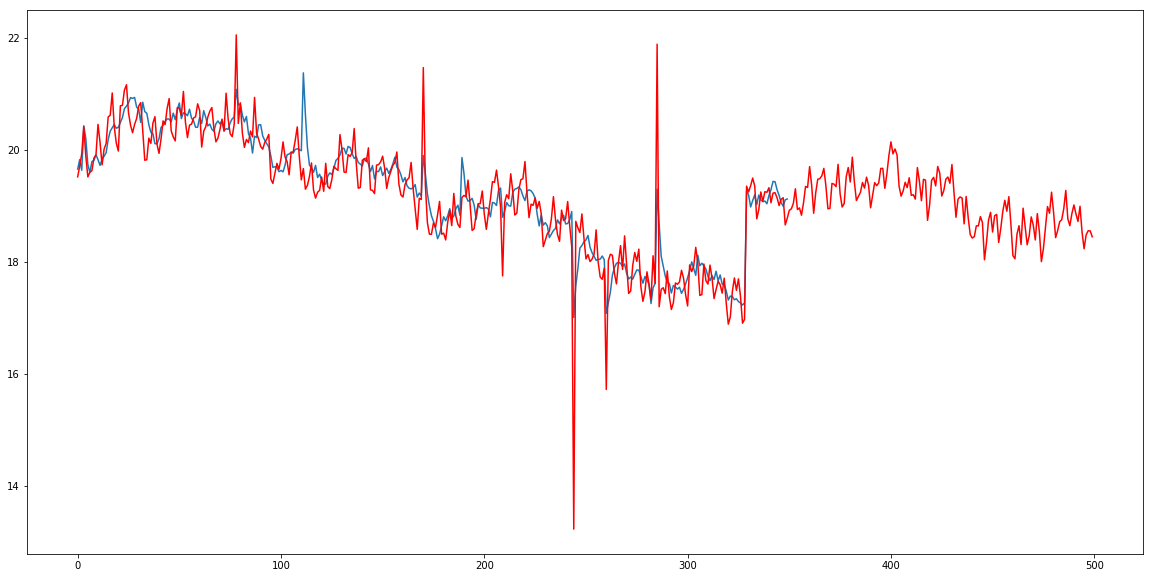

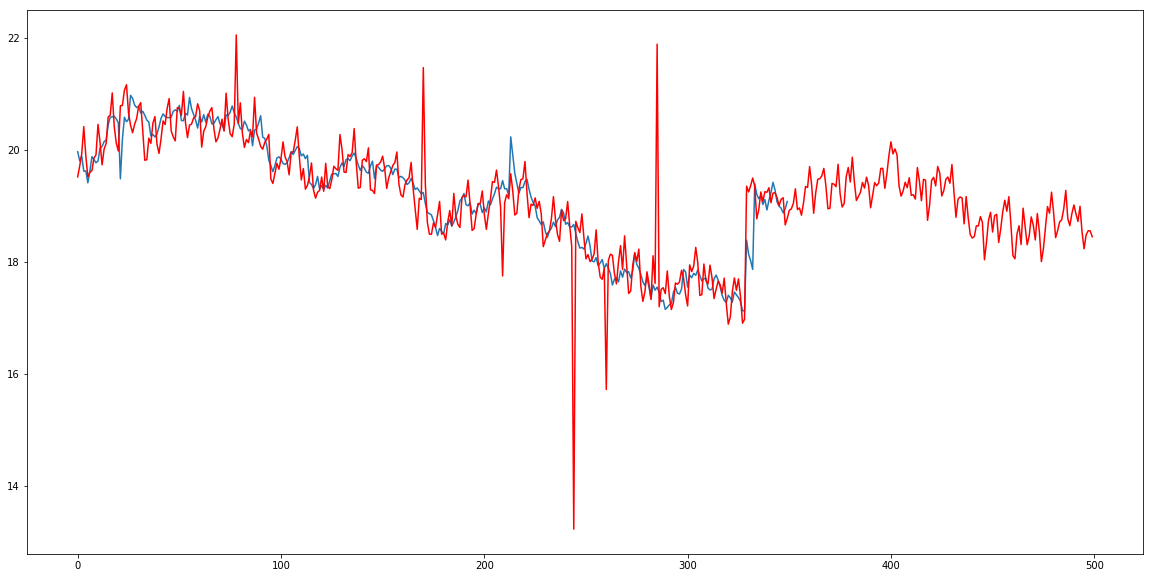

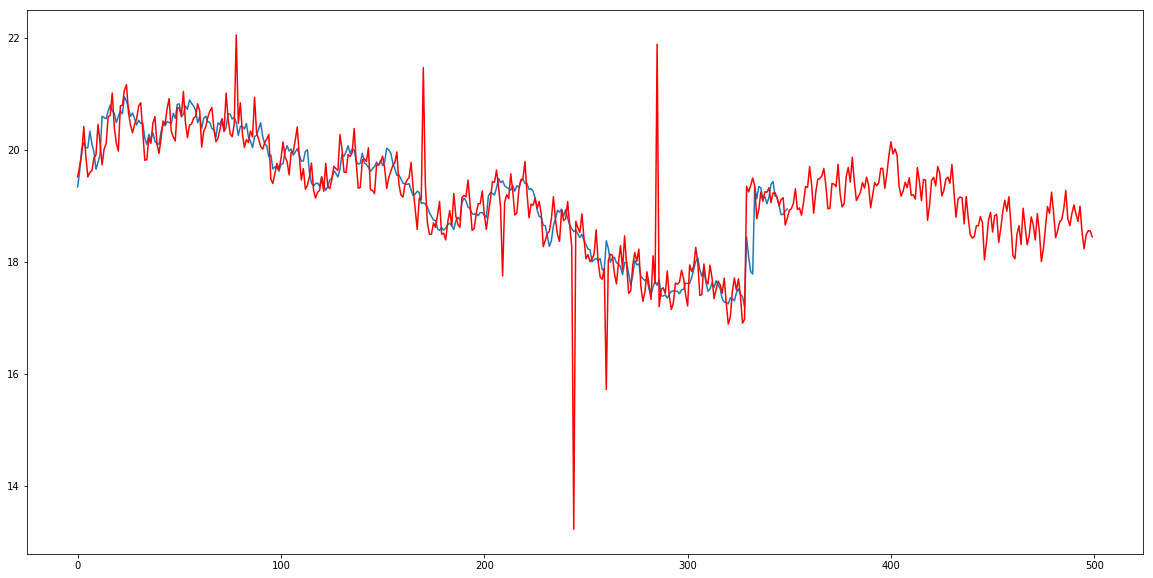

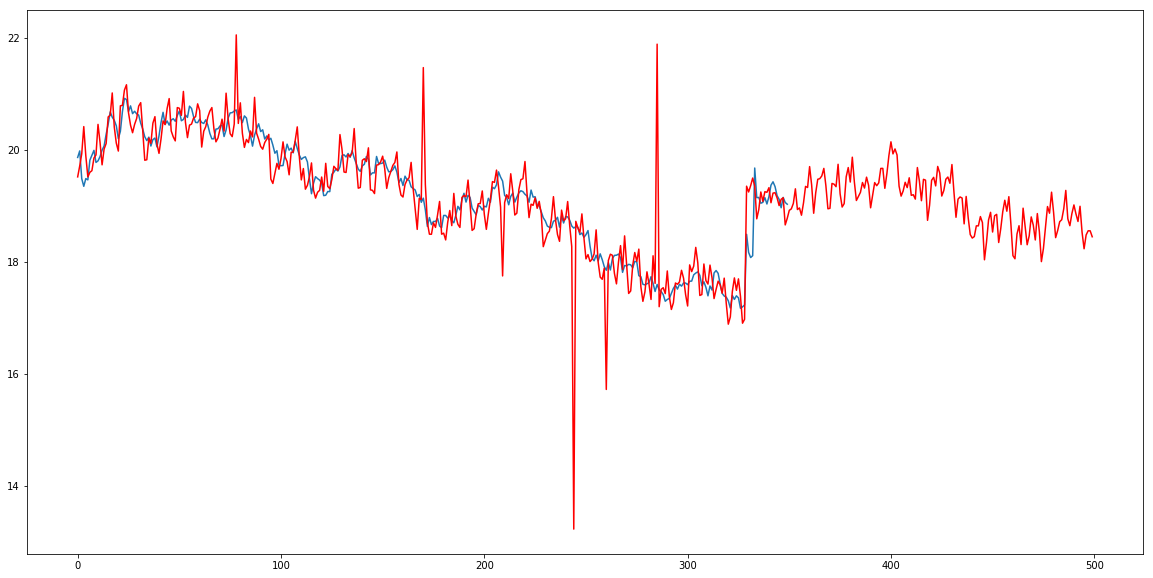

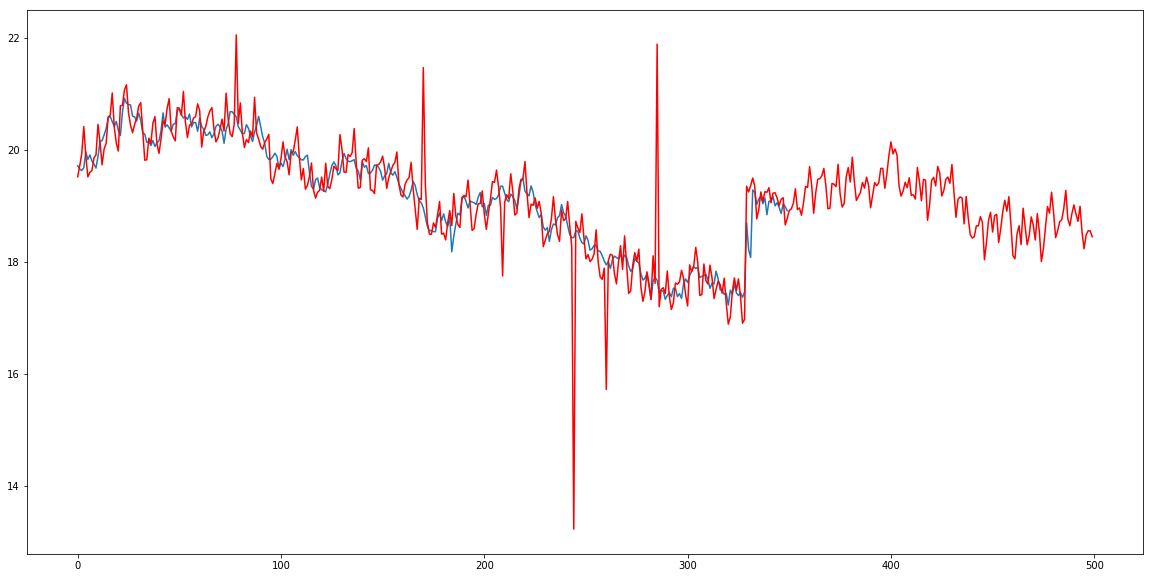

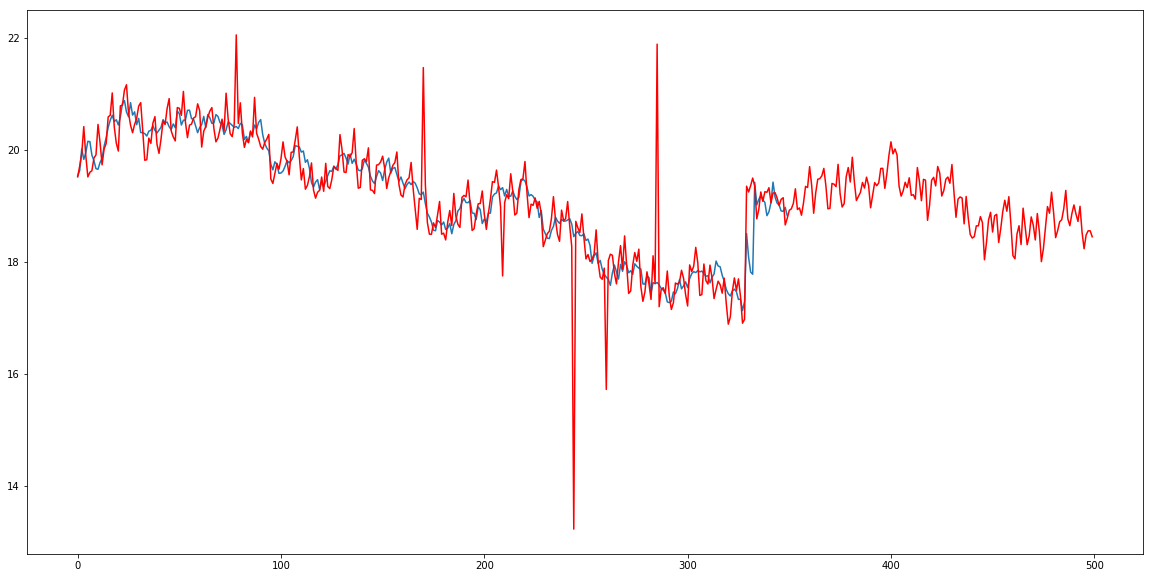

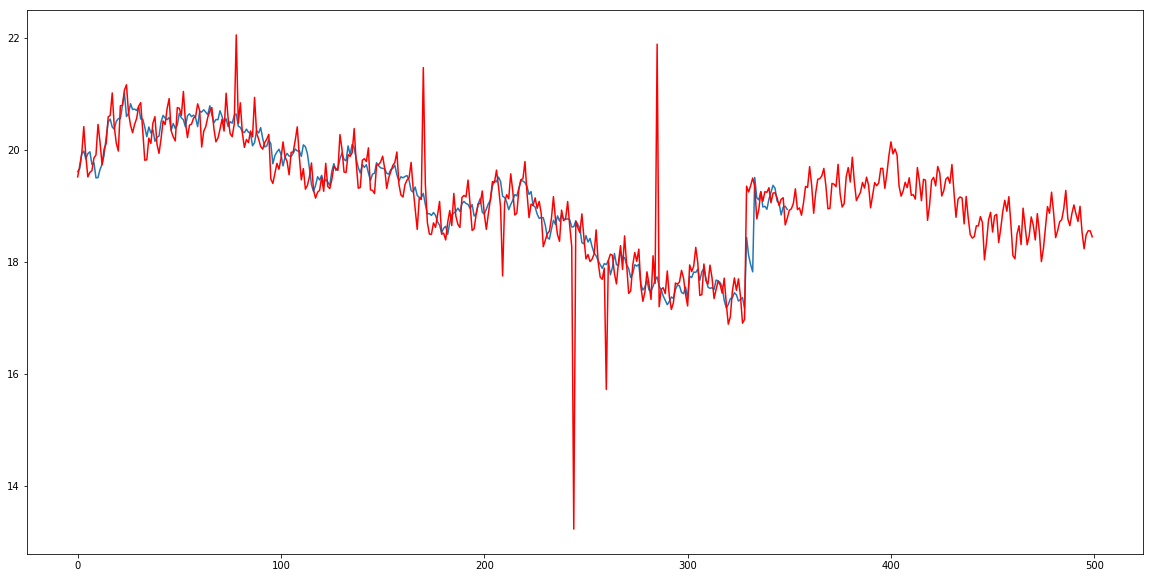

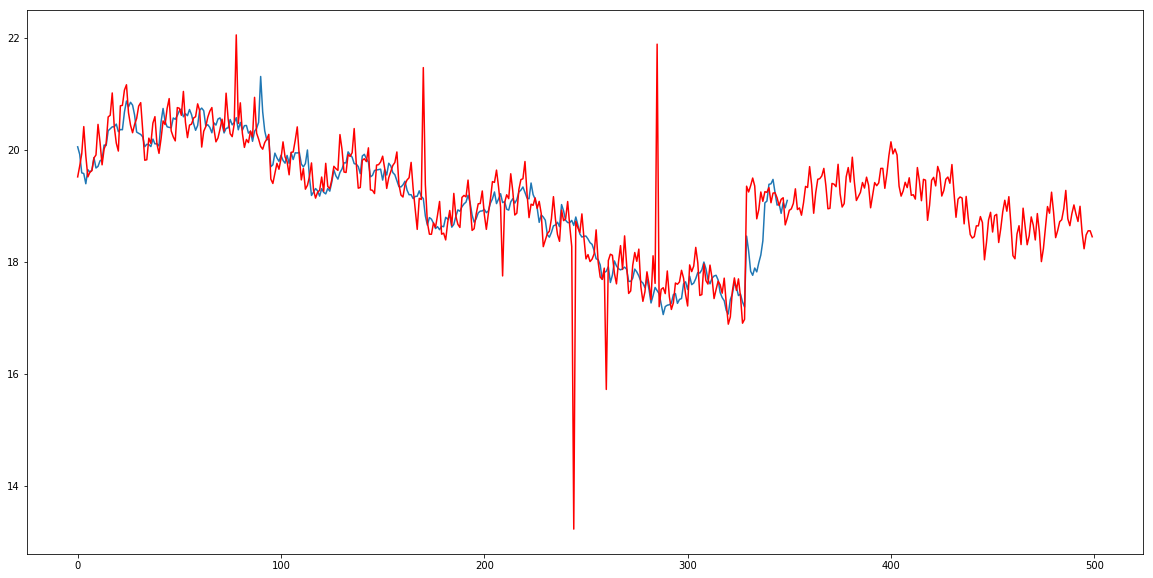

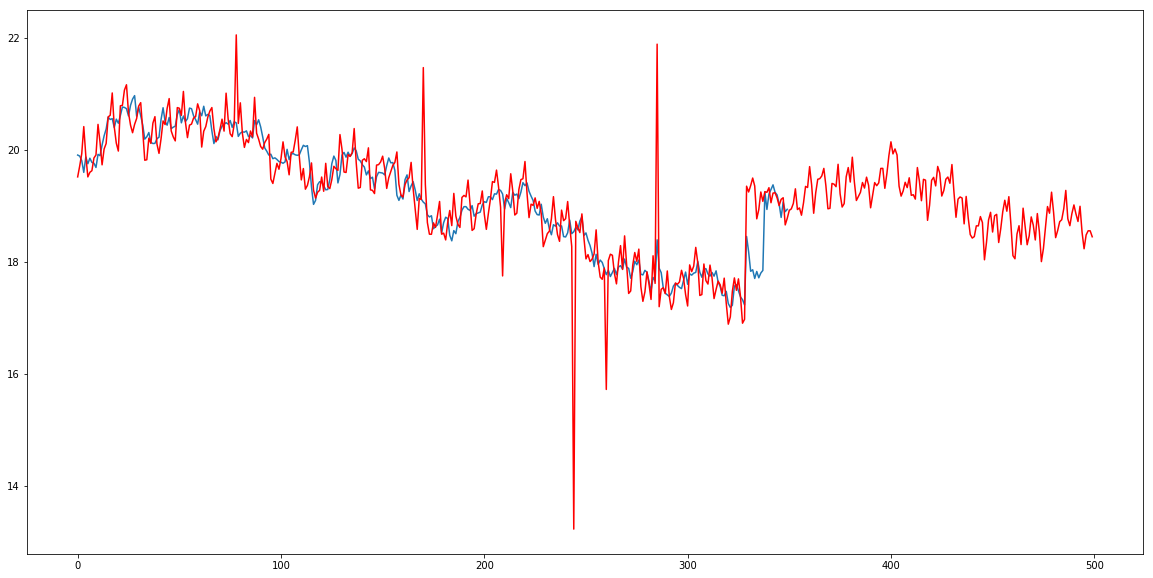

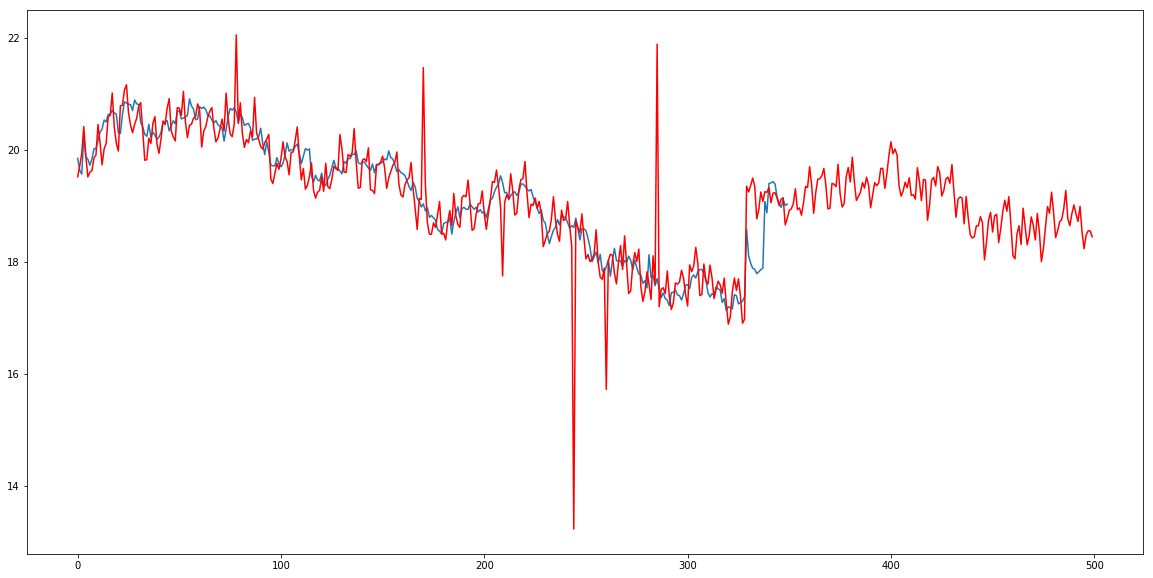

In [15]:
log_L_list = []

log_L_best = - 5 * 10**6
alpha_best = []
z_c_best = []
z_a_best = []



for epoch in range(100):
    
    print('epoch: ', epoch)
    
    # 4 Kalman and FPT
    
    d = 1000. #10e7

    P_1 = kalman_filter.gen_P_1(S, d)

    Z_t = kalman_filter.gen_Z_t(S)
    T_t = kalman_filter.gen_T_t(S)
    R_t = kalman_filter.gen_R_t(S)

    H_e = sigma_e ** 2
    H_o = sigma_o ** 2

    Q_eta = kalman_filter.gen_Q_eta(sigma_r, sigma_v, sigma_w)
    Q_xi = kalman_filter.gen_Q_eta(sigma_u, sigma_v, sigma_w)
    
    
    #kalman_filter_using_p
    
    p_a_list = p_a_evolution[-1]
    p_c_list = p_c_evolution[-1]
    
    a_t, P_t, K_t, F_t, v_t = kalman_filter.kalman_filter_using_p(L_train, y_train, a_1, P_1, Z_t, p_a_list, p_c_list, T_t, H_e, H_o, Q_eta, Q_xi, R_t)
    
    #a_t, P_t, K_t, F_t, v_t = kalman_filter.kalman_filter(L_train, y_train, a_1, P_1, Z_t, p_a, p_c, T_t, H_e, H_o, Q_eta, Q_xi, R_t)

    alpha_hat, V  = kalman_smoothing(L_train, v_t, a_t, F_t, K_t, P_t, T_t, Z_t)

    alpha_result = fake_path_trick( alpha_hat, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, p_a, p_c, L, L_train, S, t_c_fixed, c_fixed, t_r_fixed, r_fixed)

    y_result = [a[0].numpy() + a[1].numpy() for a in alpha_result ]
    
    
    if epoch % 10 == 0:
        plt.figure(figsize = (20,10))
        plt.plot(y_result)
        plt.plot(y.numpy(), 'r')
    
    
    
    
    
    #---------------------------------------------------------
    
    # 5 Update z
    
    z_a = [torch.DoubleTensor([0])]
    z_c = [torch.DoubleTensor([0])]
    p_a_new = [torch.DoubleTensor([0])]
    p_c_new = [torch.DoubleTensor([0])]

    for t in range(1,L_train):
        mu_t= alpha_result[t][0]
        y_t = y_train[t]
        gamma_t = alpha_result[t][2]

        mu_t_prev = alpha_result[t-1][0]
        delta_t_prev = alpha_result[t-1][1]

        p_a_t = update_p_a_t(p_a, sigma_o, sigma_e, y_t, mu_t, gamma_t)
        p_c_t = update_p_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev)
    
        
        z_a.append(generate_z_a_t(p_a, sigma_o, sigma_e, y_t, mu_t, gamma_t))
        z_c.append(generate_z_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev))
        p_a_new.append(p_a_t)
        p_c_new.append(p_c_t)
        
        
    
    z_a = torch.DoubleTensor(z_a)
    z_c = torch.DoubleTensor(z_c)  
    
    z_c[-1] = 0
    
    p_a_evolution.append(p_a_new)
    p_c_evolution.append(p_c_new)
    z_a_evolution.append(z_a)

    

    
    #---------------------------------------------------------
    
    # 6 Segment control
    
    
    mu = torch.DoubleTensor([a[0] for a in alpha_result])
    l = S

    z_c = segment_control(z_c, mu, sigma_r, l)
    
    z_c_evolution.append(z_c)
    
    
    
    #---------------------------------------------------------
    
    # 7 Update sigma
    
    
    mu = torch.DoubleTensor([a[0] for a in alpha_result])
    gamma  = torch.DoubleTensor([a[2] for a in alpha_result])
    delta  = torch.DoubleTensor([a[1] for a in alpha_result])
    
    delta_with_initial_values = torch.DoubleTensor([alpha_result[0][1]] + [a[1] for a in alpha_result])
    mu_with_initial_values = torch.DoubleTensor([alpha_result[0][0] - alpha_result[0][1]] + [a[0] for a in alpha_result])

    gamma_0_recalculate = []
    for i in range(S-1):
        l = len(gamma_0_recalculate)
        g = -(sum(gamma_0_recalculate) + gamma[:S-1-l].sum())

        gamma_0_recalculate.append(g)

    gamma_0_recalculate.reverse()

    gamma_with_initial_values = torch.DoubleTensor(gamma_0_recalculate + [a[2] for a in alpha_result])


    
    
    
    
    
    sigma_e = update_sigma_e(y_train, mu, gamma, z_a, sigma_e)
    sigma_o = update_sigma_o(y_train, mu, gamma, z_a, sigma_o) 


    sigma_u = update_sigma_u(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_u)
    sigma_r = update_sigma_r(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_r)

    sigma_delta = update_sigma_delta(delta, delta_with_initial_values)
    sigma_gamma = update_sigma_gamma(gamma, gamma_with_initial_values, S)
    
    sigma_v = sigma_delta
    sigma_w = sigma_gamma
    
    sigma_evolution.append(np.array([sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]))

    
    
    
    # fake sigma !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    [sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w] = sigma_true
    #sigma_true = [sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]




    #---------------------------------------------------------

    # 8 Update a_t


    a_1 = torch.zeros(S+1, dtype = torch.float64)
    a_1[:2] = alpha_result[0][:2,0]
    a_1[2:] = alpha_result[S][2:,0]
    a_1 = a_1.view(S+1, -1)
    
    
    a_1_evolution.append(a_1[:,0].numpy())
    
    
    
    
    #---------------------------------------------------------

    # 9 Calculate likelihood
    log_L = log_likelihood(y_train,mu, mu_with_initial_values, gamma, gamma_with_initial_values, delta, delta_with_initial_values, z_a, z_c, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, p_a, p_c, S)

    log_L_list.append(log_L)
    
    if log_L > log_L_best:
        log_L_best = log_L
        alpha_best = alpha_result
        
        z_c_best = z_c
        z_a_best = z_a

# anomaly

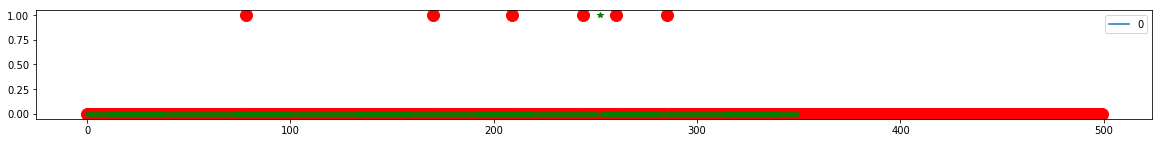

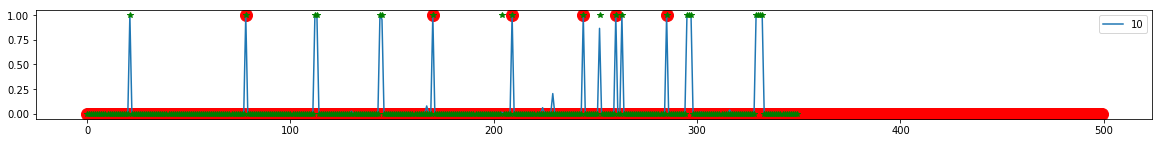

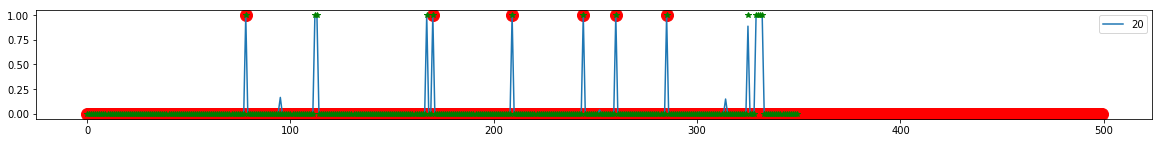

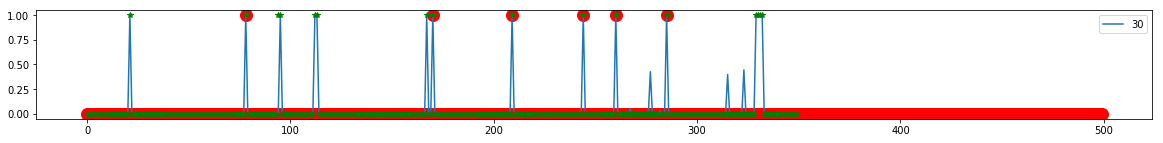

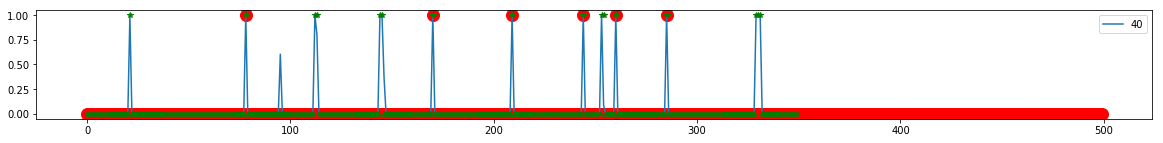

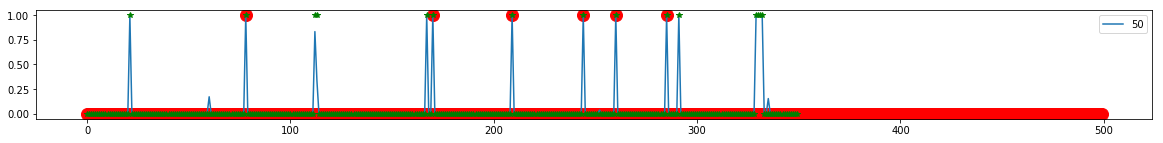

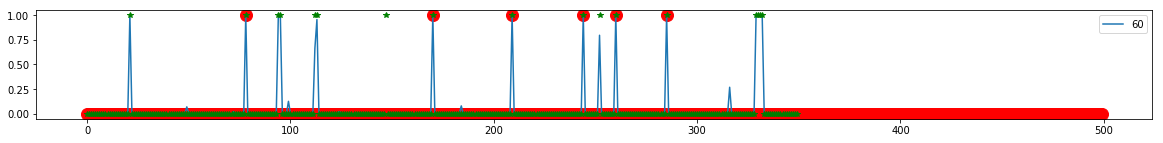

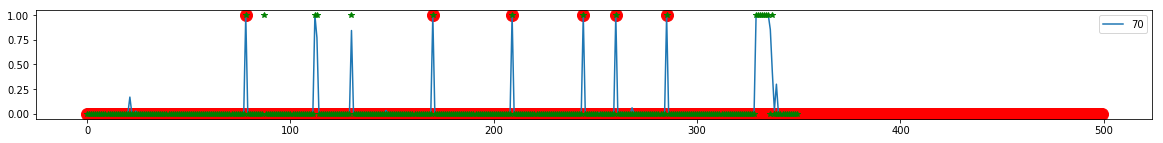

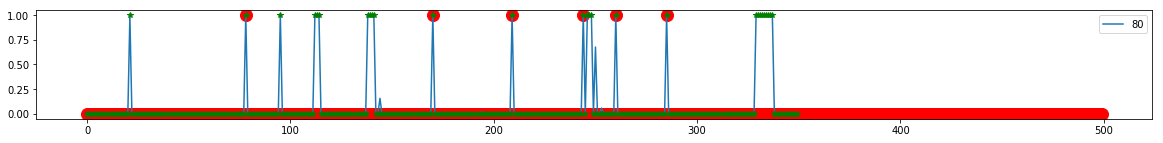

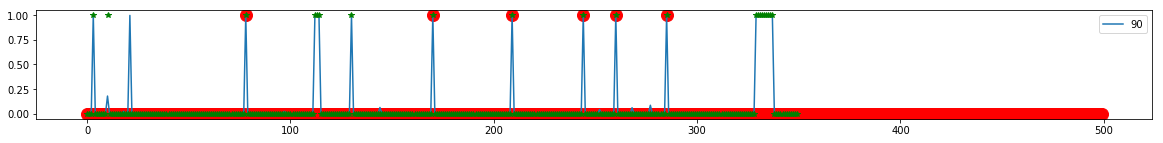

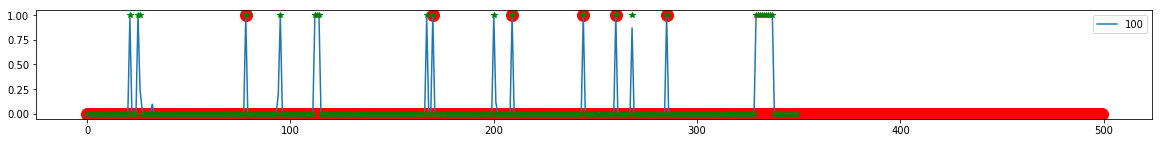

In [16]:
#plt.figure(figsize = (20,2))
#plt.plot(z_a_true.numpy(), 'ro')

for i in range(0, len(p_a_evolution), 10):#range( len(p_a_evolution)): # [1, 2, 3, 4, 5, -1]:
    plt.figure(figsize = (20,2))
    plt.plot(z_a_true.numpy(), 'ro', markersize=12)
    plt.plot(p_a_evolution[i], label = '{}'.format(i))
    plt.plot(z_a_evolution[i].numpy(), '*g')
    plt.legend()
#plt.legend()

# change

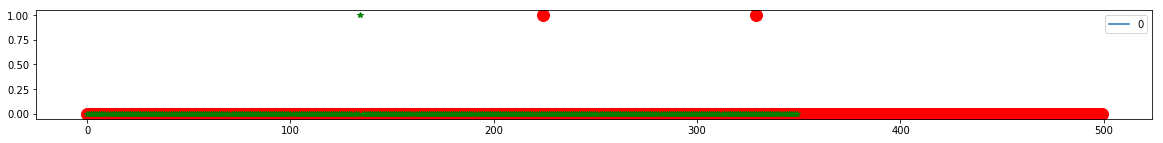

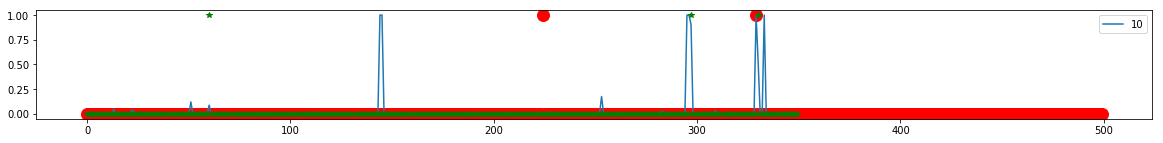

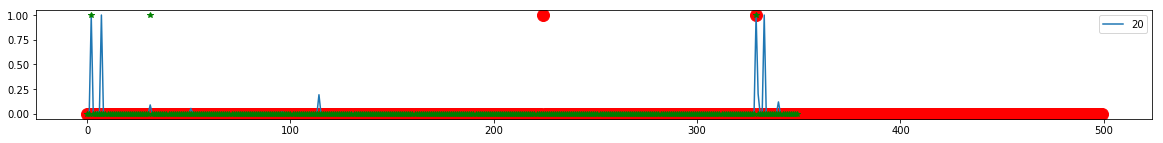

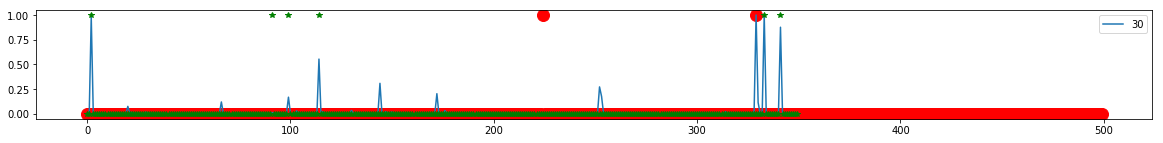

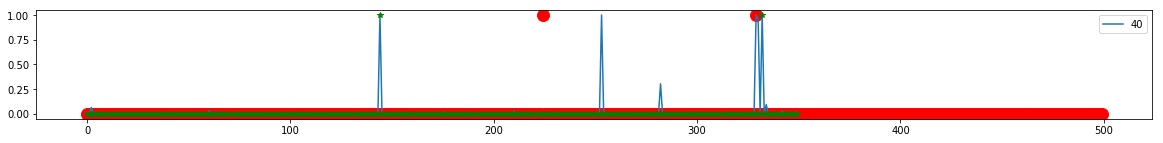

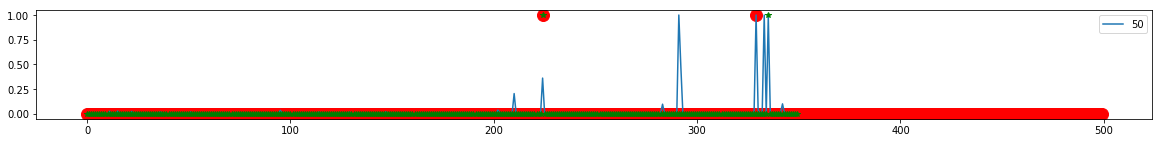

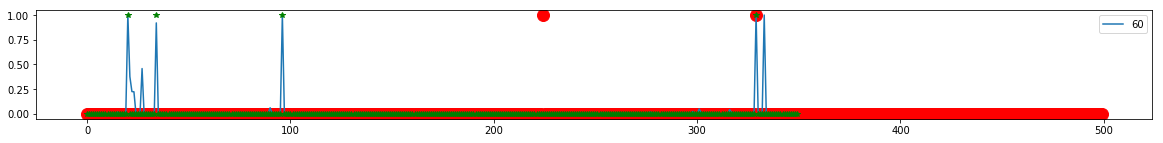

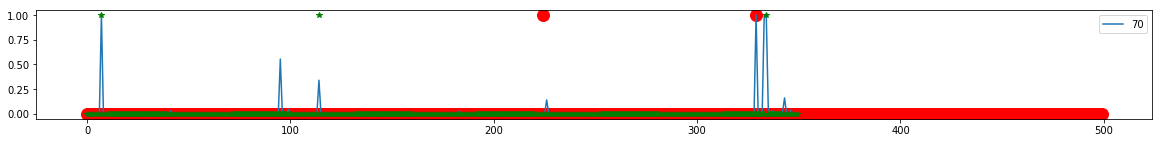

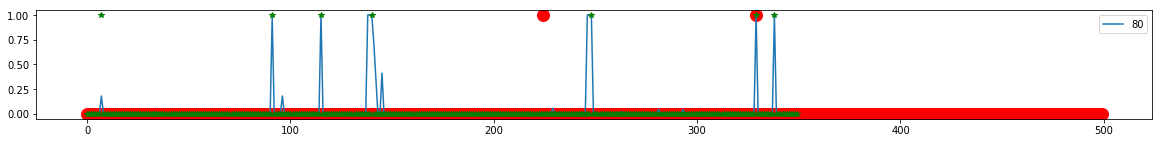

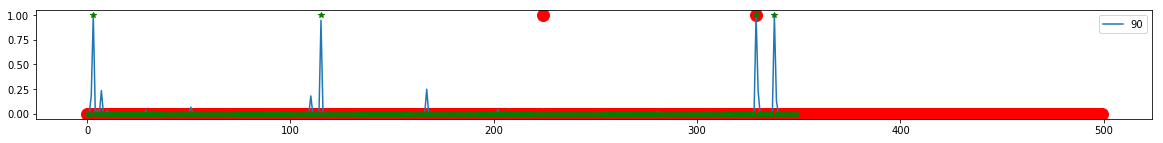

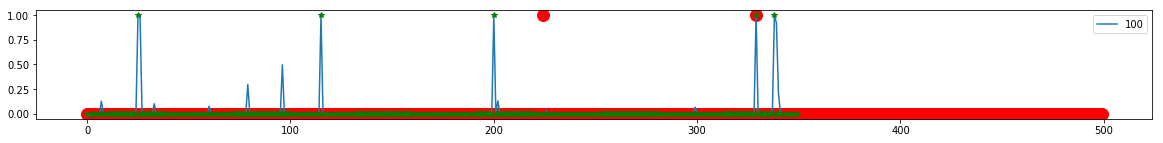

In [17]:
#plt.figure(figsize = (20,2))
#plt.plot(z_c_true.numpy(), 'ro')

for i in range(0, len(p_a_evolution), 10):# range( len(p_a_evolution)): #[1, 5, -1]:
    plt.figure(figsize = (20,2))
    plt.plot(z_c_true.numpy(), 'ro', markersize=12)
    plt.plot(p_c_evolution[i], label = '{}'.format(i))
    plt.plot(z_c_evolution[i].numpy(), '*g')
    
    plt.legend()
#plt.legend()

# Sigma

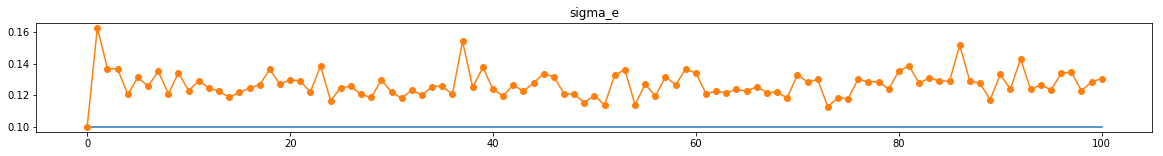

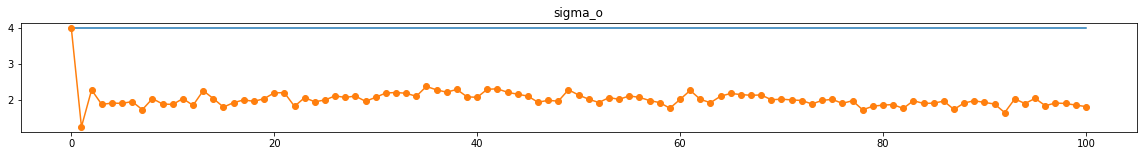

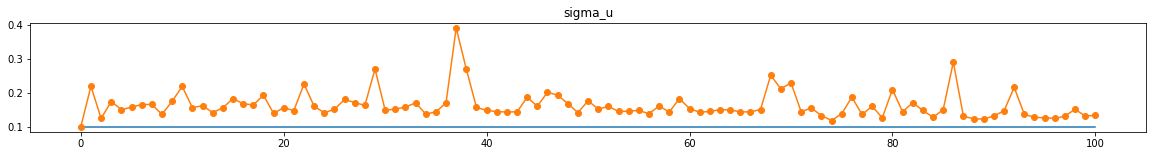

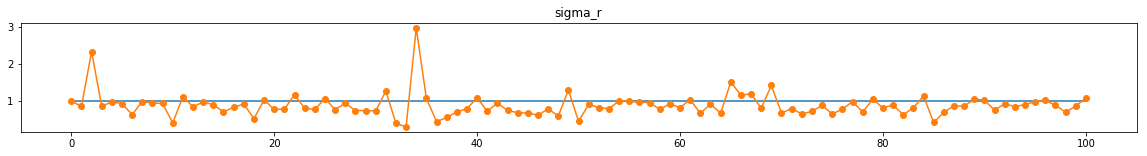

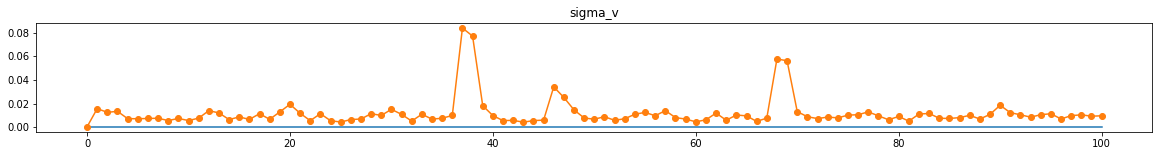

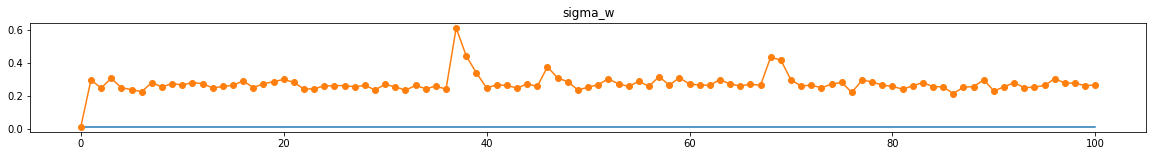

In [18]:
sigma_names = ['sigma_e', 'sigma_o', 'sigma_u', 'sigma_r', 'sigma_v', 'sigma_w']

for i in range(6):

    plt.figure(figsize=(20,2))
    plt.title(sigma_names[i])
    plt.plot(sigma_true[i] * np.ones(len(sigma_evolution)))
    plt.plot([s[i] for s in sigma_evolution], '-o')


# a_1

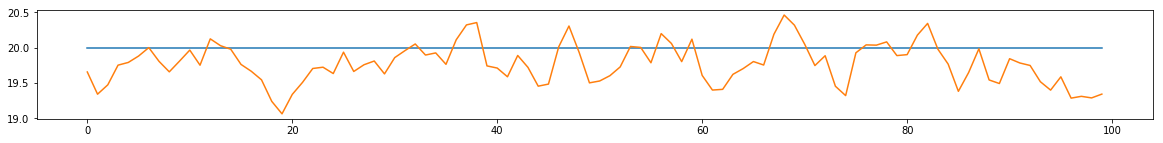

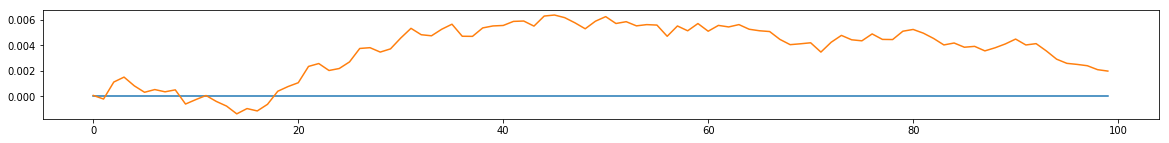

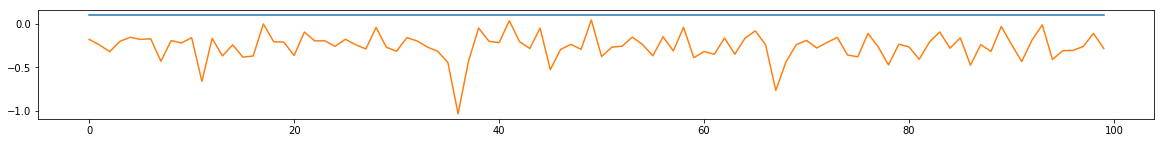

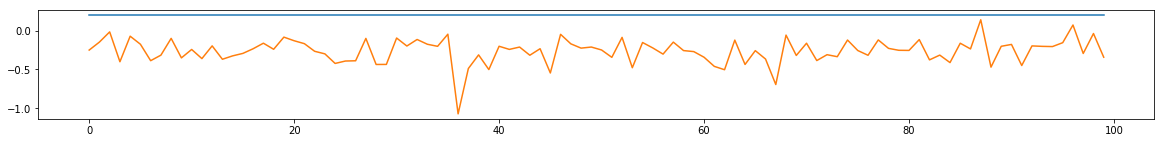

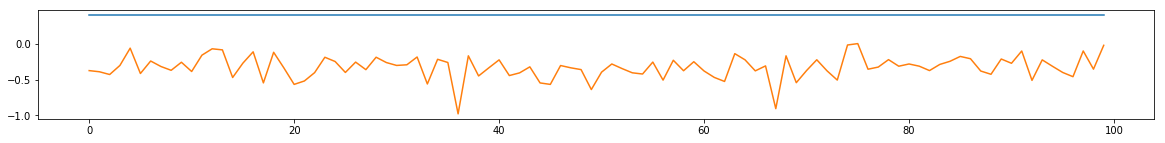

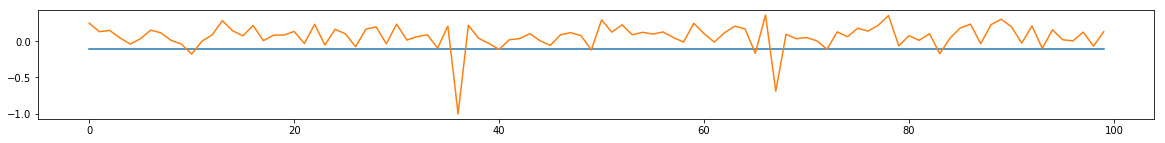

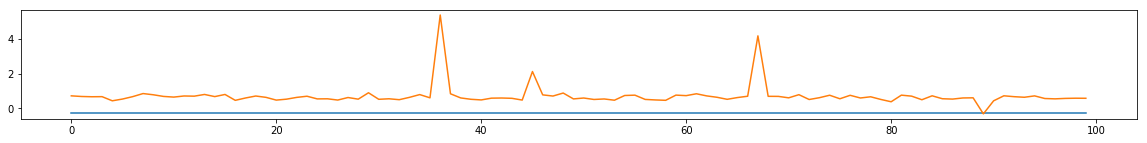

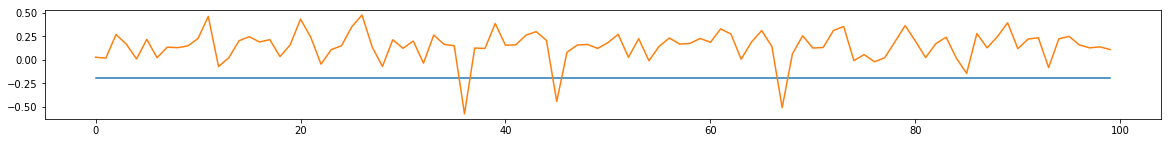

In [19]:
for i in range(S+1):
    plt.figure(figsize = (20,2))
    
    plt.plot(a_1_true[i] *  np.ones(len(a_1_evolution)))
    plt.plot([a[i] for a in a_1_evolution ])

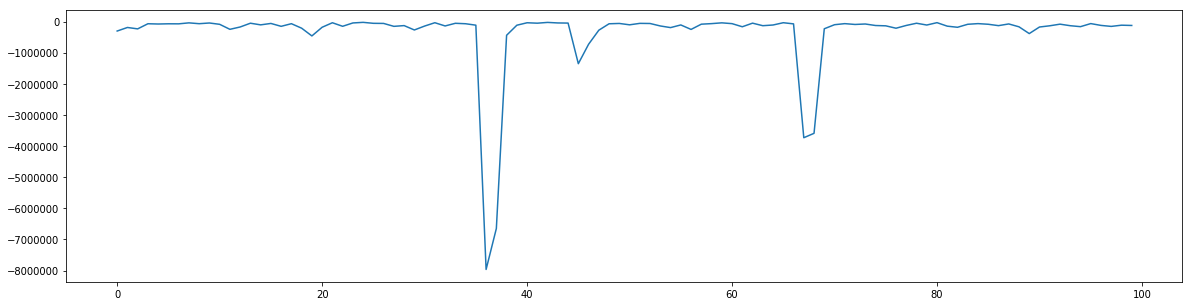

In [20]:
plt.figure(figsize = (20,5))
plt.plot(log_L_list)

# Result

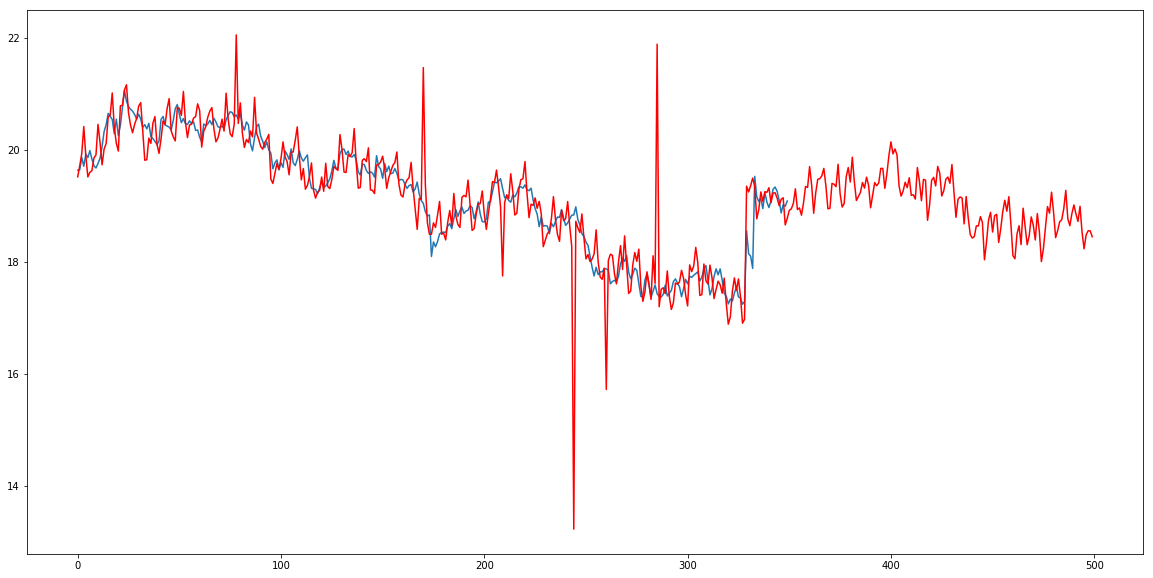

In [21]:
alpha_result = alpha_best

y_result = [a[0].numpy() + a[1].numpy() for a in alpha_result ]

plt.figure(figsize = (20,10))
plt.plot(y_result)
plt.plot(y.numpy(), 'r')
        

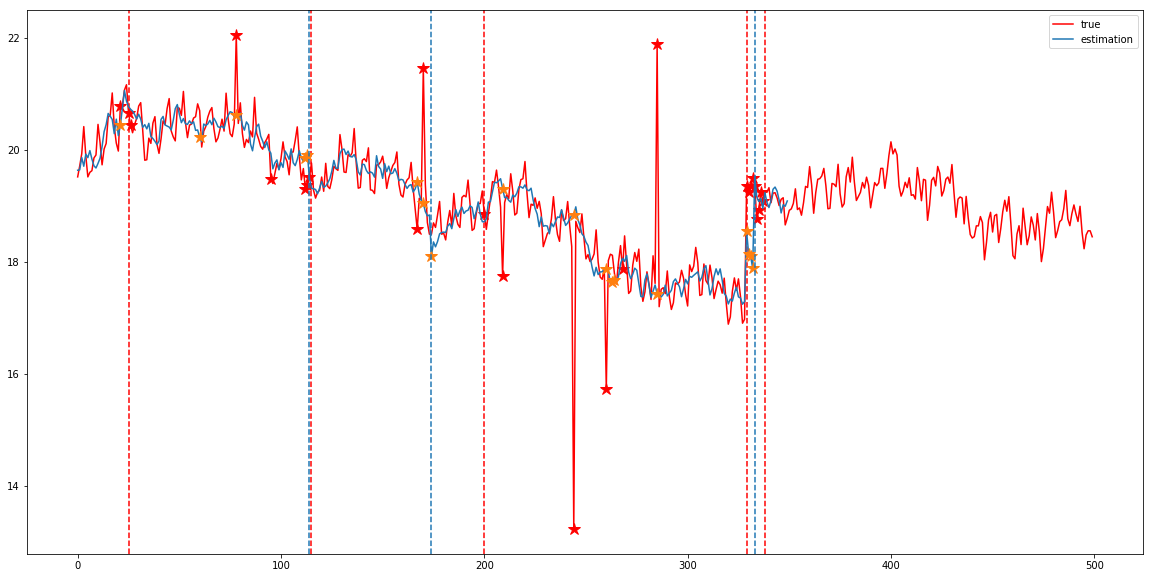

In [22]:
plt.figure(figsize = (20,10))
plt.plot(np.array(y), 'r', label = 'true')
plt.plot(np.array(torch.nonzero(z_a)),np.array(y[torch.nonzero(z_a)]), '*r', markersize=12)
for c in torch.nonzero(z_c):
    plt.axvline(x=c, linestyle='--', color='r')    
    
y_best = torch.tensor(y_result)[:,0]

plt.plot(np.array(y_result), label = 'estimation')
plt.plot(np.array(torch.nonzero(z_a_best)),np.array(y_best[torch.nonzero(z_a_best)]), '*', markersize=12)
for c in torch.nonzero(z_c_best):
    plt.axvline(x=c, linestyle='--')    
    
plt.legend()

# Forecasting

In [23]:
torch.manual_seed(4)

mu_0 = alpha_best[-1][0].numpy()
delta_0 = alpha_best[-1][1].numpy()
gamma_0 = alpha_best[-1][2:].numpy()


y_all = []
for i in range(100):
    y_f = generative_procedure_future(mu_0, delta_0, gamma_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, L - L_train, S)

    y_all.append(y_f.numpy())


In [24]:
y_all = np.array(y_all)

for t in range(y_all.shape[1]):
    y_all.sort(axis = 0)
    
y_average = y_all.mean(axis = 0)
y_low = y_all[5,:]
y_high = y_all[95,:]

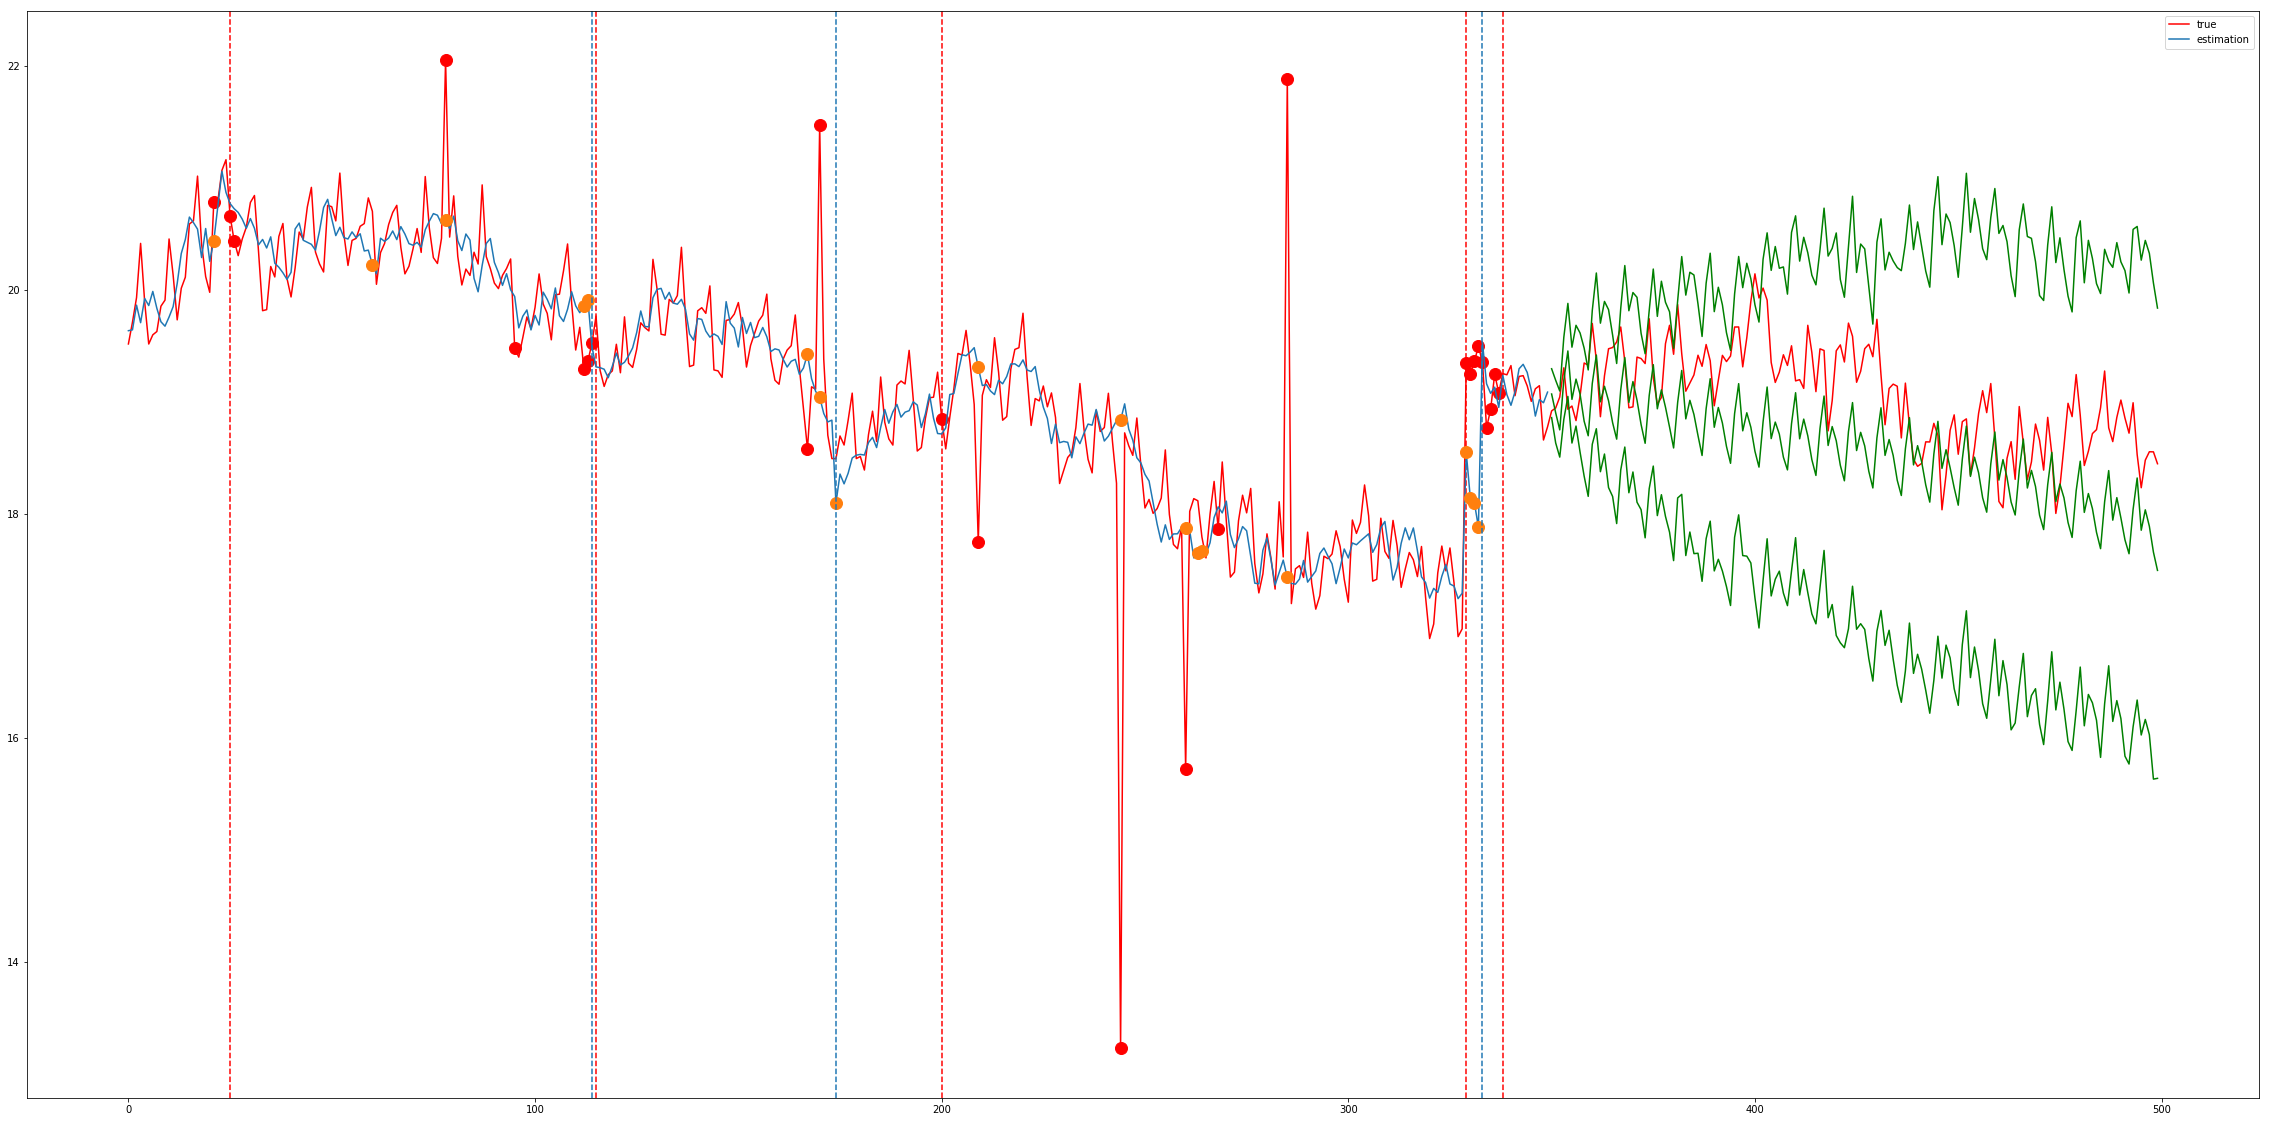

In [27]:
plt.figure(figsize = (40,20))
plt.plot(np.array(y), 'r', label = 'true')
plt.plot(np.array(torch.nonzero(z_a)),np.array(y[torch.nonzero(z_a)]), 'or', markersize=12)
for c in torch.nonzero(z_c):
    plt.axvline(x=c, linestyle='--', color='r')    
    
y_best = torch.tensor(y_result)[:,0]

plt.plot(np.array(y_result), label = 'estimation')
plt.plot(np.array(torch.nonzero(z_a_best)),np.array(y_best[torch.nonzero(z_a_best)]), 'o', markersize=12)
for c in torch.nonzero(z_c_best):
    plt.axvline(x=c, linestyle='--')    
    
    
plt.plot(np.arange(L_train, L), y_average, 'g')
plt.plot(np.arange(L_train, L), y_low, 'g')
plt.plot(np.arange(L_train, L), y_high, 'g')
plt.legend()